In [1]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import glob

In [2]:
# device = torch.device("mps")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
"""# Step 1: Get a list of all CSV file paths in the directory
data_path = glob.glob("D:\PythonProjs\CLARAi\Data\*.csv")  # Modify with your directory path
label_path = glob.glob("D:\PythonProjs\CLARAi\Label\*.csv")

# Step 2: Read each CSV file and store in a list of DataFrames
datadfs = [pd.read_csv(file) for file in data_path]
labeldfs = [pd.read_csv(file) for file in label_path]

# Step 3: Concatenate all DataFrames into one
final_data_df = pd.concat(datadfs, ignore_index=True)
final_label_df = pd.concat(labeldfs, ignore_index=True)"""

'# Step 1: Get a list of all CSV file paths in the directory\ndata_path = glob.glob("D:\\PythonProjs\\CLARAi\\Data\\*.csv")  # Modify with your directory path\nlabel_path = glob.glob("D:\\PythonProjs\\CLARAi\\Label\\*.csv")\n\n# Step 2: Read each CSV file and store in a list of DataFrames\ndatadfs = [pd.read_csv(file) for file in data_path]\nlabeldfs = [pd.read_csv(file) for file in label_path]\n\n# Step 3: Concatenate all DataFrames into one\nfinal_data_df = pd.concat(datadfs, ignore_index=True)\nfinal_label_df = pd.concat(labeldfs, ignore_index=True)'

In [4]:
def data_gen(data_path, label_path):
    final_data_df = pd.read_csv(data_path)
    final_label_df = pd.read_csv(label_path)

    train_labels_flat = final_label_df.values.flatten()
    
    # Compute class weights (inverse of class frequencies)
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_flat), y=train_labels_flat)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)

    # Parameters
    sequence_length = 256  # Length of each subsequence
    num_subsequences = 100  # Number of subsequences to extract

    # Get possible starting indices, ensuring there's enough space for a full subsequence
    possible_starts = np.arange(0, len(final_data_df) - sequence_length + 1)
    np.random.shuffle(possible_starts)

    # Select the first `num_subsequences` starting indices
    selected_starts = possible_starts[:num_subsequences]

    # Create a list to hold the subsequences
    subsequences = [final_data_df.iloc[start:start + sequence_length].values for start in selected_starts]
    sublabels = [final_label_df.iloc[start:start + sequence_length].values for start in selected_starts]

    # Convert subsequences list to a NumPy array
    subsequences_array = np.array(subsequences)
    sublabels_array = np.array(sublabels)

    # subsequences_array will have shape (num_subsequences, sequence_length, num_channels)
    # print(subsequences_array.shape)  # Should print (100, 100, 36)
    # print(sublabels_array.shape)

    return torch.from_numpy(subsequences_array), torch.from_numpy(sublabels_array), class_weights


In [5]:

# Sample time series data with shape (batch_size, sequence_length, num_features)
# neuroimaging_data: Time series data from multiple neuroimaging channels
# labels: Binary labels (0 = no pain, 1 = pain) for each time step
# Assume neuroimaging_data is a numpy array of shape (num_samples, sequence_length, num_channels)
# labels is a numpy array of shape (num_samples, sequence_length)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)  # Correct Batch Normalization
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM forward pass
        out, _ = self.lstm(x, (h0, c0))
        
        # Apply batch normalization
        # Permute to (batch_size, hidden_size, sequence_length) for batch norm
        out = out.permute(0, 2, 1)
        out = self.batch_norm(out)
        
        # Permute back to (batch_size, sequence_length, hidden_size)
        out = out.permute(0, 2, 1)
        
        # Apply the linear layer to each time step
        out = self.fc(out)
        
        return self.sigmoid(out)



In [6]:
# data_path = glob.glob("D:\PythonProjs\CLARAi\Data_norm\*.csv")  # Modify with your directory path
# label_path = glob.glob("D:\PythonProjs\CLARAi\Label\*.csv")

# data_path = glob.glob("/home/frank/Documents/CLARAi/Data/*.csv")  # Modify with your directory path
# label_path = glob.glob("/home/frank/Documents/CLARAi/Label/*.csv")

# data_path = glob.glob("/Users/xiaosuhu/Documents/Python/CLARAi/Data/*.csv")  # Modify with your directory path
# label_path = glob.glob("/Users/xiaosuhu/Documents/Python/CLARAi/Data/*.csv")

data_path = glob.glob("/kaggle/input/clarai/CLARAi/Data/*.csv")  # Modify with your directory path
label_path = glob.glob("/kaggle/input/clarai/CLARAi/Label/*.csv")

# Sort the lists
data_path = sorted(data_path)
label_path = sorted(label_path)


In [7]:

# data_path = "D:\PythonProjs\CLARAi\Data\data1.csv"
# label_path = "D:\PythonProjs\CLARAi\Label\label1.csv"
neuroimaging_data = torch.empty(0,256,36)
labels = torch.empty(0,256,1)
class_weights = torch.Tensor([0., 0.])

In [8]:

for datapath, labelpath in zip(data_path, label_path):
    print(f'datapath: {datapath}')
    print(f'labelpath: {labelpath}')    
    data, label, weight = data_gen(datapath, labelpath)
    print(f'Data shape: {data.shape}, Label shape: {label.shape}, Weight shape: {weight.shape}')
    neuroimaging_data= torch.cat([neuroimaging_data, data])
    labels = torch.cat([labels, label])
    class_weights += weight

normalized_weights = class_weights / class_weights.sum()


datapath: /kaggle/input/clarai/CLARAi/Data/data1.csv
labelpath: /kaggle/input/clarai/CLARAi/Label/label1.csv
Data shape: torch.Size([100, 256, 36]), Label shape: torch.Size([100, 256, 1]), Weight shape: torch.Size([2])
datapath: /kaggle/input/clarai/CLARAi/Data/data10.csv
labelpath: /kaggle/input/clarai/CLARAi/Label/label10.csv
Data shape: torch.Size([100, 256, 36]), Label shape: torch.Size([100, 256, 1]), Weight shape: torch.Size([2])
datapath: /kaggle/input/clarai/CLARAi/Data/data11.csv
labelpath: /kaggle/input/clarai/CLARAi/Label/label11.csv
Data shape: torch.Size([100, 256, 36]), Label shape: torch.Size([100, 256, 1]), Weight shape: torch.Size([2])
datapath: /kaggle/input/clarai/CLARAi/Data/data12.csv
labelpath: /kaggle/input/clarai/CLARAi/Label/label12.csv
Data shape: torch.Size([100, 256, 36]), Label shape: torch.Size([100, 256, 1]), Weight shape: torch.Size([2])
datapath: /kaggle/input/clarai/CLARAi/Data/data13.csv
labelpath: /kaggle/input/clarai/CLARAi/Label/label13.csv
Data sh

In [9]:
neuroimaging_data.shape, labels.shape

(torch.Size([1500, 256, 36]), torch.Size([1500, 256, 1]))

In [10]:
# Count the number of 1s
num_zeros = torch.sum(labels == 0).item()
num_ones = torch.sum(labels == 1).item()

print(f"Number of 0s: {num_zeros}Number of 1s: {num_ones} Ratio is {num_ones/(num_ones + num_zeros)}")

Number of 0s: 293722Number of 1s: 90278 Ratio is 0.23509895833333333


In [11]:
# Hyperparameters
input_size = neuroimaging_data.shape[2]  # Number of features (channels)
hidden_size = 64  # Hidden state size of the GRU
output_size = 1  # Binary classification
num_layers = 6  # Number of GRU layers
learning_rate = 0.001
num_epochs = 500
batch_size = 32

# Preprocessing (e.g., normalization)
# scaler = StandardScaler()
# neuroimaging_data = scaler.fit_transform(neuroimaging_data.reshape(-1, input_size)).reshape(neuroimaging_data.shape)

# Convert numpy arrays to PyTorch tensors
train_data, test_data, train_labels, test_labels = train_test_split(neuroimaging_data, labels, test_size=0.2, random_state=42)
train_data, test_data = torch.tensor(train_data, dtype=torch.float32).to(device), torch.tensor(test_data, dtype=torch.float32).to(device)
train_labels, test_labels = torch.tensor(train_labels, dtype=torch.float32).to(device), torch.tensor(test_labels, dtype=torch.float32).to(device)


# Create GRU model
model = LSTMClassifier(input_size, hidden_size, output_size, num_layers).to(device)

# Loss and optimizer
# criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification


# Convert the class weights to a tensor and move to the appropriate device
class_weights = class_weights.to(device)

# Use BCEWithLogitsLoss, which combines sigmoid activation and binary cross-entropy loss
criterion = nn.BCEWithLogitsLoss(pos_weight=normalized_weights[0])  # pos_weight applies only to class 1

# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

/tmp/ipykernel_24/2731089170.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_data, test_data = torch.tensor(train_data, dtype=torch.float32).to(device), torch.tensor(test_data, dtype=torch.float32).to(device)
/tmp/ipykernel_24/2731089170.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels, test_labels = torch.tensor(train_labels, dtype=torch.float32).to(device), torch.tensor(test_labels, dtype=torch.float32).to(device)


In [12]:
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()
    
    # Forward pass (training)
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)
    
    # Backward pass and optimization
    loss.backward()
    
    # Clip gradients to prevent exploding gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()

    # Validation phase (no gradient calculations)
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for validation
        val_outputs = model(test_data)
        val_loss = criterion(val_outputs, test_labels)

    # Update learning rate if validation loss plateaus
    scheduler.step(val_loss)

    # Print loss every 5 epochs
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')


Epoch [5/500], Train Loss: 0.7501, Val Loss: 0.7581
Epoch [10/500], Train Loss: 0.6904, Val Loss: 0.7293
Epoch [15/500], Train Loss: 0.6626, Val Loss: 0.6891
Epoch [20/500], Train Loss: 0.6533, Val Loss: 0.6828
Epoch [25/500], Train Loss: 0.6456, Val Loss: 0.6974
Epoch [30/500], Train Loss: 0.6368, Val Loss: 0.7214
Epoch [35/500], Train Loss: 0.6278, Val Loss: 0.7421
Epoch [40/500], Train Loss: 0.6186, Val Loss: 0.7417
Epoch [45/500], Train Loss: 0.6173, Val Loss: 0.6924
Epoch [50/500], Train Loss: 0.6160, Val Loss: 0.6631
Epoch [55/500], Train Loss: 0.6148, Val Loss: 0.6466
Epoch [60/500], Train Loss: 0.6136, Val Loss: 0.6364
Epoch [65/500], Train Loss: 0.6125, Val Loss: 0.6298
Epoch [70/500], Train Loss: 0.6115, Val Loss: 0.6253
Epoch [75/500], Train Loss: 0.6104, Val Loss: 0.6221
Epoch [80/500], Train Loss: 0.6095, Val Loss: 0.6197
Epoch [85/500], Train Loss: 0.6086, Val Loss: 0.6178
Epoch [90/500], Train Loss: 0.6077, Val Loss: 0.6161
Epoch [95/500], Train Loss: 0.6069, Val Loss: 0

Accuracy: 88.82%
Confusion Matrix:
[[55679  3160]
 [ 5423 12538]]


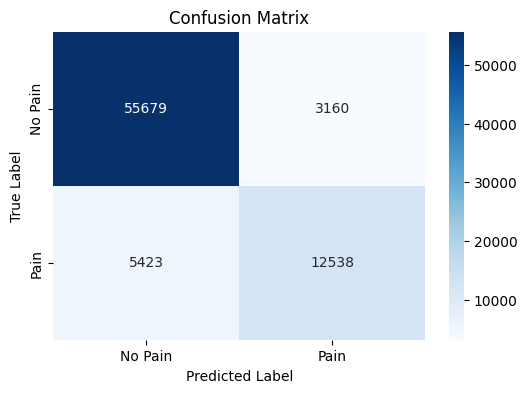

In [13]:

model.eval()
with torch.no_grad():
    test_outputs = model(test_data)
    predicted = (test_outputs > 0.5).float()  # Threshold at 0.5 for binary classification
    
    # Calculate accuracy
    accuracy = (predicted == test_labels).float().mean()
    print(f'Accuracy: {accuracy.item() * 100:.2f}%')

    # Flatten the predicted and test labels for confusion matrix calculation
    predicted_flat = predicted.cpu().numpy().flatten()
    test_labels_flat = test_labels.cpu().numpy().flatten()

    # Generate the confusion matrix
    cm = confusion_matrix(test_labels_flat, predicted_flat)
    print(f'Confusion Matrix:\n{cm}')

    # Optional: plot the confusion matrix for visualization
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['No Pain', 'Pain'], yticklabels=['No Pain', 'Pain'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()


In [14]:
def plot_roc_auc(model, test_data, test_labels):
    model.eval()
    with torch.no_grad():
        # Get the raw logits (before applying sigmoid)
        test_outputs = model(test_data)
        
        # Convert test_labels and test_outputs to NumPy arrays for sklearn
        test_labels_flat = test_labels.cpu().numpy().flatten()
        test_outputs_flat = test_outputs.cpu().numpy().flatten()

        # Calculate the false positive rate, true positive rate, and thresholds for the ROC curve
        fpr, tpr, thresholds = roc_curve(test_labels_flat, test_outputs_flat)
        
        # Calculate the AUC score
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.figure(figsize=(8,6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='grey', linestyle='--')  # Random classifier line
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate (FPR)')
        plt.ylabel('True Positive Rate (TPR)')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc='lower right')
        plt.show()

    return roc_auc

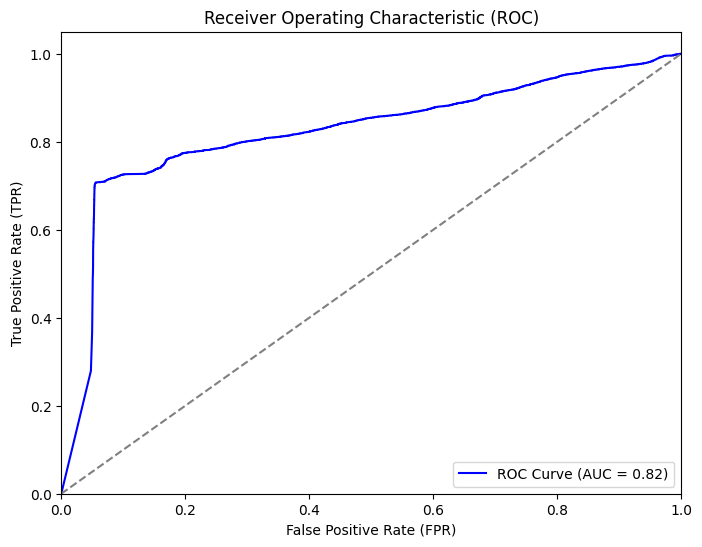

0.8234114590158874

In [15]:
plot_roc_auc(model, test_data, test_labels)